In [20]:
#!/usr/bin/env python3

import logging
import os
import subprocess
import time

import matplotlib.pyplot as plt
import numpy as np
from sympy import I
#import vmec
from mpi4py import MPI

from neat.fields import StellnaQS, Vmec
from neat.tracing import ChargedParticle, ParticleOrbit

Trace the orbit of a single particle in a
quasisymmetric stellarator using Near Axis and VMEC   

In [36]:
# Initialize an alpha particle at a radius = r_initial
s_boundary = 0.1
s_initial = 0.1    # psi/psi_a for vmec
theta_initial = np.pi   # initial poloidal angle
phi_initial = np.pi/2    # initial toroidal angle
B0 = 5            # Tesla, magnetic field on-axis
energy = 3.52e6     # electron-volt
charge = 2          # times charge of proton
mass = 4            # times mass of proton
Lambda = 0.5        # = mu * B0 / energy
vpp_sign = -1       # initial sign of the parallel velocity, +1 or -1
nsamples = 1000     # resolution in time
tfinal = 2.5e-7    # seconds
constant_b20 =False # use a constant B20 (mean value) or the real function
filename = "input.nearaxis"
wout_filename = "wout_nearaxis.nc"

In [37]:
g_field = StellnaQS.from_paper(1, B0=B0, nphi=201)
# g_field.to_vmec(filename=filename)
# subprocess.run(["./xvmec2000", filename])
g_field_vmec = Vmec(wout_filename=wout_filename)

In [38]:
g_particle = ChargedParticle(
    r_initial = 0.1*np.sqrt(s_initial),#s=np.sqrt(2*r_initial*psi_a/B0) bc # psi_a=(B0*0.1*0.1)/2
    theta_initial = theta_initial,
    phi_initial = phi_initial,    
    energy = energy,
    Lambda = Lambda,
    charge = charge,
    mass = mass,
    vpp_sign = vpp_sign,
)

g_particle_vmec = ChargedParticle(
    r_initial = s_initial,
    theta_initial = np.pi - theta_initial,     
    phi_initial = g_field.to_RZ([[0.1*np.sqrt(s_initial),theta_initial,phi_initial]])[2][0],    
    energy = energy,
    Lambda = Lambda,
    charge = charge,
    mass = mass,
    vpp_sign = vpp_sign,
)

In [39]:
g_orbit = ParticleOrbit(
    g_particle, 
    g_field, 
    nsamples = nsamples, 
    tfinal = tfinal, 
    constant_b20 = constant_b20
)

In [40]:

g_orbit_vmec = ParticleOrbit(
    g_particle_vmec,
    g_field_vmec,
    nsamples = nsamples,
    tfinal = tfinal,
    constant_b20 = constant_b20,
)


In [41]:
#Calculating differences between near axis and vmec

diff_r = (
        g_orbit.rpos_cylindrical[0] - g_orbit_vmec.rpos_cylindrical[0]
    ) / g_orbit_vmec.rpos_cylindrical[0]
# diff_Z = (g_orbit.rpos_cylindrical[1] - g_orbit_vmec.rpos_cylindrical[1]
#     ) / (np.max(abs(g_orbit_vmec.rpos_cylindrical[1])))
diff_Z = g_orbit.rpos_cylindrical[1] - g_orbit_vmec.rpos_cylindrical[1]
diff_phi= (
    np.unwrap(np.mod(g_orbit.rpos_cylindrical[2], 2*np.pi)) - np.unwrap(np.mod(g_orbit_vmec.rpos_cylindrical[2], 2*np.pi))
) / (2 * np.pi)


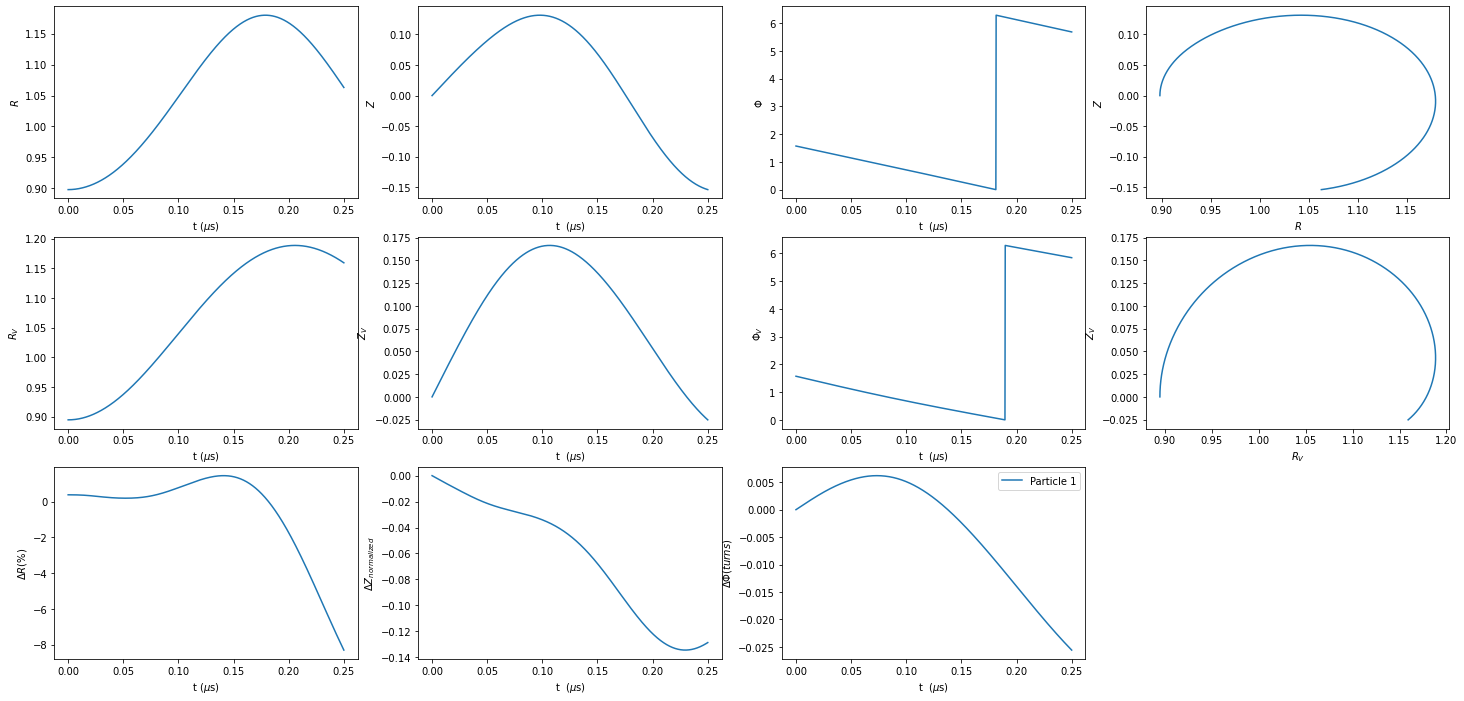

In [42]:
_ = plt.figure(figsize=(25, 12))
plt.subplot(3, 4, 1)
plt.plot(g_orbit.time*1e6, g_orbit.rpos_cylindrical[0], label='Particle 1')
plt.xlabel(r't ($\mu$s)')
plt.ylabel(r'$R$')
plt.subplot(3, 4, 2)
plt.plot(g_orbit.time*1e6, g_orbit.rpos_cylindrical[1], label='Particle 1')
plt.xlabel(r't  ($\mu$s)')
plt.ylabel(r'$Z$')
plt.subplot(3, 4, 3)
plt.plot(g_orbit.time*1e6, np.mod(g_orbit.rpos_cylindrical[2], 2*np.pi), label='Particle 1')
plt.xlabel(r't  ($\mu$s)')
plt.ylabel(r'$\Phi$')
plt.subplot(3, 4, 4)
plt.plot(g_orbit.rpos_cylindrical[0], g_orbit.rpos_cylindrical[1], label='Particle 1')
plt.xlabel(r'$R$')
plt.ylabel(r'$Z$')
plt.subplot(3, 4, 5)
plt.plot(g_orbit_vmec.time*1e6, g_orbit_vmec.rpos_cylindrical[0], label='Particle 1')
plt.xlabel(r't ($\mu$s)')
plt.ylabel(r'$R_V$')
plt.subplot(3, 4, 6)
plt.plot(g_orbit_vmec.time*1e6, g_orbit_vmec.rpos_cylindrical[1], label='Particle 1')
plt.xlabel(r't  ($\mu$s)')
plt.ylabel(r'$Z_V$')
plt.subplot(3, 4, 7)
plt.plot(g_orbit_vmec.time*1e6, np.mod(g_orbit_vmec.rpos_cylindrical[2], 2*np.pi), label='Particle 1')
plt.xlabel(r't  ($\mu$s)')
plt.ylabel(r'$\Phi_V $')
plt.subplot(3, 4, 8)
plt.plot(g_orbit_vmec.rpos_cylindrical[0], g_orbit_vmec.rpos_cylindrical[1], label='Particle 1')
plt.xlabel(r'$R_V$')
plt.ylabel(r'$Z_V$')
plt.subplot(3, 4, 9)
plt.plot(g_orbit_vmec.time*1e6, diff_r*100, label='Particle 1')
plt.xlabel(r't ($\mu$s)')
plt.ylabel(r'$\Delta  R (\%)$')
plt.subplot(3, 4, 10)
plt.plot(g_orbit_vmec.time*1e6, diff_Z, label='Particle 1')
plt.xlabel(r't  ($\mu$s)')
plt.ylabel(r'$\Delta  Z_{normalized}$')
plt.subplot(3, 4, 11)
plt.plot(g_orbit_vmec.time*1e6, diff_phi, label='Particle 1')
plt.xlabel(r't  ($\mu$s)')
plt.ylabel(r'$\Delta \Phi (turns)$')
#plt.subplot(3, 4, 12)
#plt.plot(diff_r,diff_Z, label='Particle 1')
#plt.xlabel(r'$\Delta R$')
#plt.ylabel(r'$\Delta Z$')
#plt.title('First particle tracing')
plt.legend()
plt.show()

In [19]:
print(g_orbit.r_pos)

[0.03162278 0.03162278 0.03162278 ... 0.03157506 0.03157496 0.03157487]


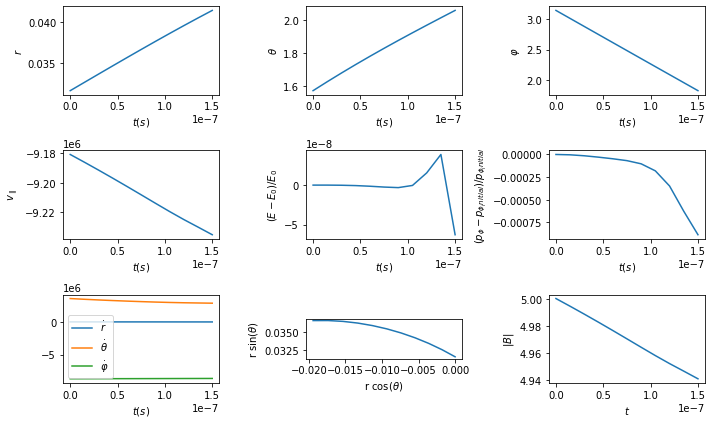

In [415]:
#Creating parameter plot for NA
g_orbit.plot(show=True)

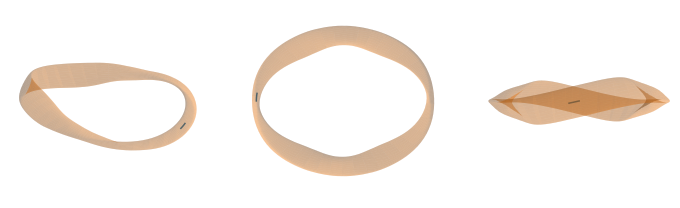

In [337]:
#Creating 3D plot for NA
g_orbit.plot_orbit_3d(show=False)

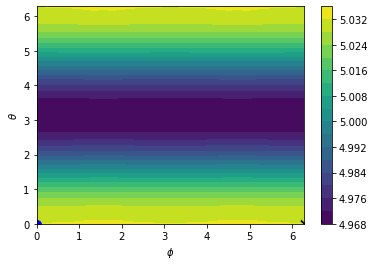

In [338]:
#Creating B contour plot for NA
g_orbit.plot_orbit_contourB(show=False)

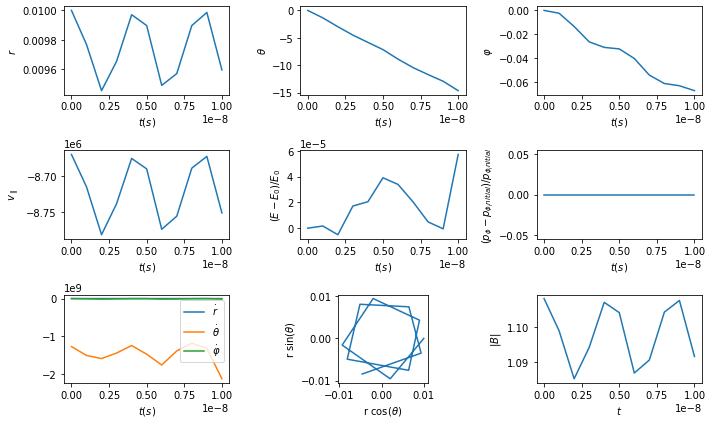

In [339]:
#Creating parameter plot for VMEC
g_orbit_vmec.plot(show=True)

In [340]:
# print("Creating 2D plot")
# g_orbit.plot_orbit(show=False)

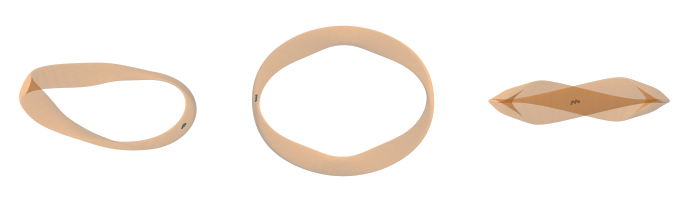

In [341]:
#Creating 3D plot for VMEC
g_orbit_vmec.plot_orbit_3d(show=False)

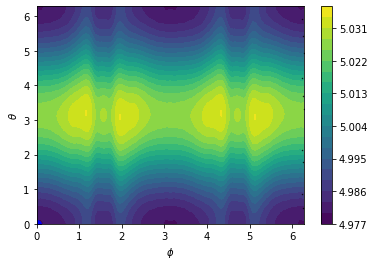

In [342]:
#Creating B contour plot for VMEC
g_orbit_vmec.plot_orbit_contourB(show=False)

In [343]:
# Not working yet?
# print("Creating animation plot")
# anim=g_orbit.plot_animation(show=True)